### Author
 - Gioele Modica

In [17]:
import os
import pydicom
import numpy as np
from pydicom import dcmread
from pydicom.dataset import Dataset
import matplotlib.pyplot as plt
import highdicom as hd
from ipywidgets import interact, IntSlider

FOLDER_PATH = '1493/20_PP_Ax5.00mm' 
SEG_PATH = '1493/30_EQP_Ax5.00mm_ManualROI_Tumor.dcm' 

# Functions

In [18]:
def explore_dataset_structure():
    """
    Explore the DICOM dataset structure and print information about found series.
        
    Returns:
        dict: Dictionary containing information about found series
    """
    dataset_info = {
        'ct_series': [],
    }
    
    for root, dirs, files in os.walk(FOLDER_PATH):
        for file in files:
            if file.endswith('.dcm'):
                file_path = os.path.join(root, file)
                try:
                    ds = dcmread(file_path, stop_before_pixels=True)
                    
                    ct_info = {
                        'path': file_path,
                        'series_description': ds.get('SeriesDescription', ''),
                        'series_instance_uid': ds.get('SeriesInstanceUID', ''),
                        'instance_number': ds.get('InstanceNumber', 0),
                        'acquisition_number': ds.get('AcquisitionNumber', 0)
                    }
                    dataset_info['ct_series'].append(ct_info)
                except Exception as e:
                    print(f"Error reading {file_path}: {str(e)}")
    
    # Print summary information
    print(f"Found {len(dataset_info['ct_series'])} DICOM images")
    
    # Print unique series descriptions
    ct_series_descriptions = set([s['series_description'] for s in dataset_info['ct_series']])
    print("\nCT Series Descriptions:")
    for desc in ct_series_descriptions:
        print(f"- {desc}")
    
    return dataset_info

In [19]:
def load_dicom_series():
    """
    Load and sort a DICOM series from a specified folder, ensuring uniform shape.

    Returns:
        list: List of pydicom.Dataset objects sorted
        np.ndarray: 3D volume
    """
    # Elenco dei file .dcm nella cartella specificata
    dicom_files = [os.path.join(FOLDER_PATH, f) for f in os.listdir(FOLDER_PATH) if f.endswith('.dcm')]
    
    if not dicom_files:
        raise ValueError(f"No DICOM files found in folder: {FOLDER_PATH}")
    
    slices = []
    for fp in dicom_files:
        try:
            ds = dcmread(fp)
            # Considera solo i file che hanno pixel_array
            _ = ds.pixel_array  
            slices.append(ds)
        except Exception as e:
            print(f"Skipping {fp}: {e}")

    if not slices:
        raise ValueError("No valid CT slices loaded.")

    # Filtra solo quelli con shape uguale al primo
    ref_shape = slices[0].pixel_array.shape
    uniform_slices = [ds for ds in slices if ds.pixel_array.shape == ref_shape]
    if len(uniform_slices) < len(slices):
        print(f"Warning: scartate {len(slices)-len(uniform_slices)} slice(s) non-conforming.")

    # Dividi in quelli con ImagePositionPatient e fallback su InstanceNumber
    with_pos = [ds for ds in uniform_slices if 'ImagePositionPatient' in ds]
    without_pos = [ds for ds in uniform_slices if 'ImagePositionPatient' not in ds]

    with_pos.sort(key=lambda ds: float(ds.ImagePositionPatient[2]))
    without_pos.sort(key=lambda ds: int(ds.InstanceNumber))

    sorted_slices = with_pos + without_pos

    # Crea il volume 3D
    volume = np.stack([ds.pixel_array for ds in sorted_slices])
    return sorted_slices, volume

In [20]:
def show_dicom_slice(volume, slice_idx, title='DICOM Slice', cmap='gray'):
    """
    Display a single slice from a DICOM volume.
    
    Args:
        volume (numpy.ndarray): 3D DICOM volume
        slice_idx (int): Index of the slice to display
        title (str): Title for the plot
        cmap (str): Colormap to use for display
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(volume[slice_idx], cmap=cmap)
    plt.title(f"{title} - Slice {slice_idx}")
    plt.axis('off')
    plt.show()

In [21]:
def apply_dicom_modality_lut(pixel_array, ds):
    """
    Apply modality LUT to convert pixel values to Hounsfield Units.
    
    Args:
        pixel_array (numpy.ndarray): Raw pixel data
        ds (pydicom.Dataset): DICOM dataset containing required tags
        
    Returns:
        numpy.ndarray: Pixel values in Hounsfield Units
    """
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        return pixel_array * ds.RescaleSlope + ds.RescaleIntercept
    return pixel_array

In [22]:
def load_and_sort_ct_series(directory_path):
    """
    Load and sort a CT series from a directory containing DICOM files.
    
    Args:
        directory_path (str): Path to the directory containing DICOM files of the CT series
        
    Returns:
        list: List of sorted pydicom.Dataset objects
        numpy.ndarray: 3D volume of Hounsfield Units
    """
    # Get list of DICOM files in directory
    dicom_files = [f for f in os.listdir(directory_path) if f.endswith('.dcm')]
    
    # Read all DICOM files (without pixel data first to check headers)
    slices = []
    for filename in dicom_files:
        filepath = os.path.join(directory_path, filename)
        ds = dcmread(filepath, stop_before_pixels=True)
        slices.append(ds)
    
    # Verify this is a CT series
    if not all('ImageType' in ds and 'ORIGINAL' in ds.ImageType for ds in slices):
        print("Warning: Not all slices appear to be original CT images")
    
    # Sort slices based on slice location (ImagePositionPatient)
    slices.sort(key=lambda ds: float(ds.ImagePositionPatient[2]))
    
    # Now load pixel data for sorted slices
    for i, ds in enumerate(slices):
        ds.file_meta = dcmread(os.path.join(directory_path, dicom_files[i])).file_meta
        ds.pixel_array = dcmread(os.path.join(directory_path, dicom_files[i])).pixel_array
    
    # Convert to Hounsfield Units if needed
    volume = np.stack([apply_dicom_modality_lut(ds.pixel_array, ds) for ds in slices])
    
    return slices, volume

In [23]:
def explore_ct_volume(volume):
    """
    Create an interactive widget to explore CT volume slices.
    
    Args:
        volume (numpy.ndarray): 3D CT volume data
    """
    def display_slice(slice_idx):
        plt.figure(figsize=(10, 8))
        plt.imshow(volume[slice_idx], cmap='gray', vmin=-100, vmax=300)  # Typical WW/WL for abdominal CT
        plt.title(f"Slice {slice_idx}")
        plt.axis('off')
        plt.show()
    
    interact(display_slice, 
            slice_idx=IntSlider(min=0, max=len(volume)-1, step=1, value=len(volume)//2,
                            layout={'width': '100%'}))

In [24]:
def show_multiplanar_reconstruction(volume):
    ax_idx = volume.shape[0] // 2
    sag_idx = volume.shape[1] // 2
    cor_idx = volume.shape[2] // 2

    for name, img in [('Axial', volume[ax_idx]),
                        ('Sagittal', volume[:, sag_idx, :].T),
                        ('Coronal', volume[:, :, cor_idx].T)]:
        plt.figure(figsize=(6,6))
        plt.imshow(img, cmap='gray', aspect='auto')
        plt.title(f'{name} View')
        plt.axis('off')
        plt.show()


In [25]:
def load_segmentation():
    """
    Load DICOM segmentation file with robust error handling.
    Supports multiple highdicom versions.
    """
    
    try:
        seg = hd.seg.segread(SEG_PATH)
        segments_info = []
        
        # Try different methods based on version
        if hasattr(seg, 'segment_numbers'):
            for segment in seg.segment_numbers:
                try:
                    # Try public API first
                    mask = seg.get_segment_mask(segment)
                except AttributeError:
                    try:
                        # Fallback to internal method
                        mask = seg._get_segment_data(segment)
                    except AttributeError:
                        raise RuntimeError("Could not find segment mask extraction method")
                
                description = seg.get_segment_description(segment)
                segments_info.append({
                    'number': segment,
                    'description': description,
                    'mask': mask
                })
            return segments_info
        else:
            raise RuntimeError("Unsupported highdicom version - segment_numbers not available")
    except Exception as e:
        print(f"Error loading segmentation: {str(e)}")
        raise

In [26]:
def load_segmentation():
    """
    Load a DICOM segmentation by reading pixel_array e SegmentSequence.
    Supporta sia un singolo segmento sia N segmenti impilati.
    """
    ds = dcmread(SEG_PATH)
    # estrai la maschera raw (shape = [frames, rows, cols])
    mask_array = ds.pixel_array  
    # prendi la lista dei segmenti dal DICOM tag
    seg_seq = ds.get('SegmentSequence', [])
    n_seg = len(seg_seq)
    segments_info = []

    # Se c'è un solo segmento, tutta la pixel_array è la sua maschera
    if n_seg == 1:
        description = seg_seq[0].get('SegmentDescription', '')
        segments_info.append({
            'number': seg_seq[0].SegmentNumber,
            'description': description,
            'mask': mask_array
        })
    else:
        # Suddividi i frame equamente fra i segmenti
        frames_per_seg = mask_array.shape[0] // n_seg
        for i, seg_item in enumerate(seg_seq):
            seg_mask = mask_array[i*frames_per_seg : (i+1)*frames_per_seg]
            description = seg_item.get('SegmentDescription', '')  
            segments_info.append({
                'number': seg_item.SegmentNumber,
                'description': description,
                'mask': seg_mask
            })

    return segments_info


In [27]:
def show_segmentation_overlay(ct_slice, mask_slice, title='Segmentation Overlay'):
    """
    Display CT slice with segmentation overlay.

    Args:
        ct_slice (numpy.ndarray): 2D CT slice
        mask_slice (numpy.ndarray): 2D segmentation mask
        title (str): Plot title
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(ct_slice, cmap='gray')
    plt.imshow(np.ma.masked_where(mask_slice == 0, mask_slice), 
                cmap='jet', alpha=0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [28]:
def normalize_image(img):
    """
    Normalize image values to 0-255 for better visualization.

    Args:
        img (numpy.ndarray): Input image

    Returns:
        numpy.ndarray: Normalized image
    """
    img = img - np.min(img)
    img = img / np.max(img)
    img = (img * 255).astype(np.uint8)
    return img


In [29]:
def create_mip_animation(ct_volume, mask_volume, output_path='mip_animation.gif'):
    """
    Create rotating MIP animation optimized.

    Args:
        ct_volume (numpy.ndarray): CT volume
        mask_volume (numpy.ndarray): Mask volume
        output_path (str): Save path
    """
    import imageio
    from scipy.ndimage import rotate

    frames = []
    angles = np.arange(0, 360, 5)

    # Compute MIP only once
    mip_ct = np.max(ct_volume, axis=0)
    mip_mask = np.max(mask_volume, axis=0)

    for angle in angles:
        rotated_mip = rotate(mip_ct, angle, reshape=False, axes=(0, 1))
        rotated_mask = rotate(mip_mask, angle, reshape=False, axes=(0, 1))

        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(rotated_mip.T, cmap='gray')
        ax.imshow(np.ma.masked_where(rotated_mask.T == 0, rotated_mask.T), cmap='jet', alpha=0.3)
        ax.axis('off')
        plt.tight_layout()

        fig.canvas.draw()
        frame = np.array(fig.canvas.renderer.buffer_rgba())
        frame = normalize_image(frame) 
        frames.append(frame)
        plt.close()

    imageio.mimsave(output_path, frames, duration=0.2)
    print(f"Saved optimized animation to {output_path}")


In [30]:
def execute():
    """
    Main function to execute the DICOM processing and visualization.
    """
    # Explore dataset structure
    explore_dataset_structure()
    
    # Load CT series
    _, ct_volume = load_dicom_series()

    # Show a slice of the CT volume
    explore_ct_volume(ct_volume)
    
    # Show multiplanar views
    show_multiplanar_reconstruction(ct_volume)
    
    # Load segmentation
    segmentation_info = load_segmentation()
    
    # Visualizza overlay per ogni segmento
    for segment in segmentation_info:
        mask = segment['mask']
        mask_slice = mask[mask.shape[0] // 2]
        ct_slice = ct_volume[ct_volume.shape[0] // 2]
        show_segmentation_overlay(ct_slice, mask_slice,
                                title=f"Segment {segment['number']} - {segment['description']}")
        
        # Crea una MIP animata per ogni segmento
        output_gif = f"animation_segment_{segment['number']}.gif"
        create_mip_animation(ct_volume, mask, output_path=output_gif)


# Execution

Found 92 DICOM images

CT Series Descriptions:
- 20_PP_Ax5.00mm


interactive(children=(IntSlider(value=46, description='slice_idx', layout=Layout(width='100%'), max=91), Outpu…

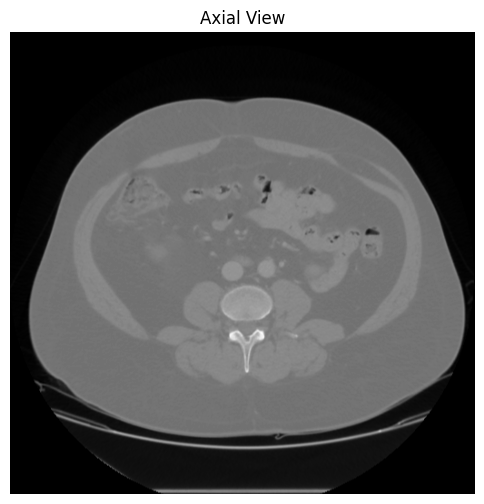

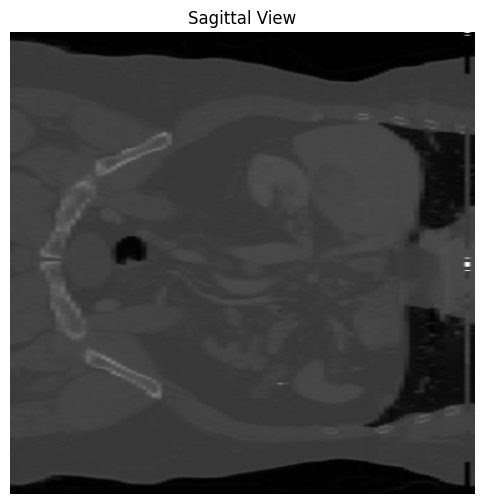

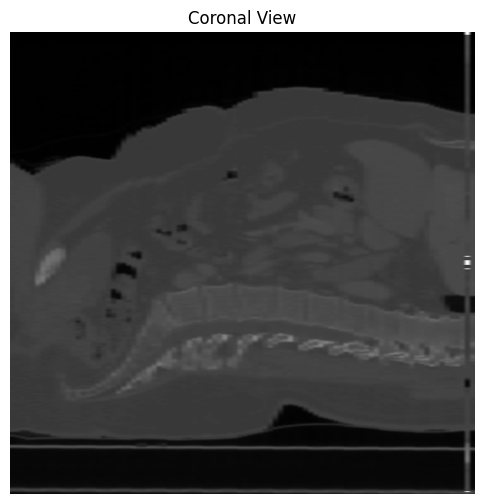

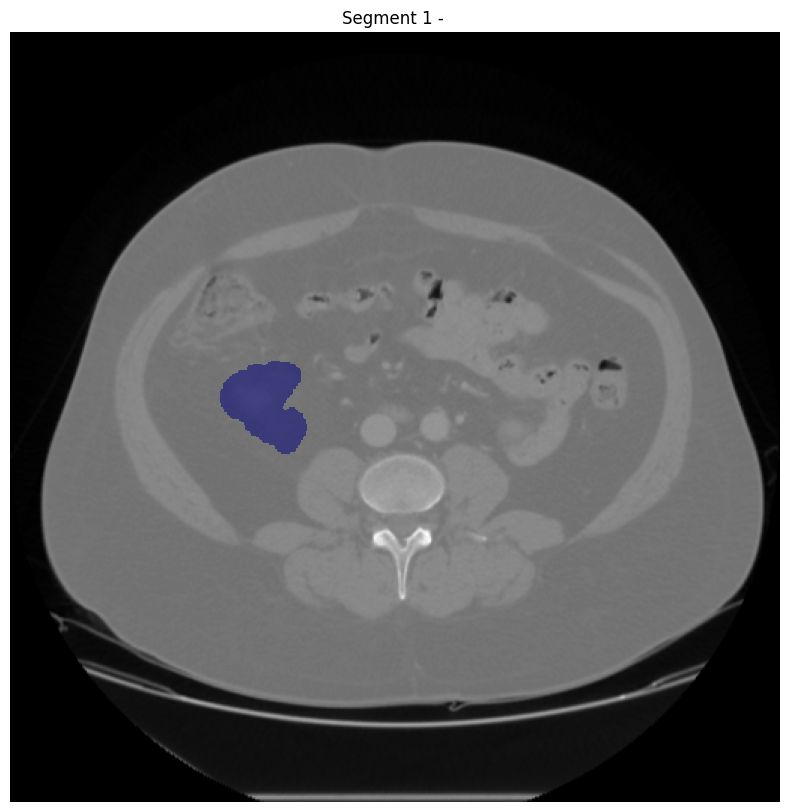

Saved optimized animation to animation_segment_1.gif


In [31]:
execute()